In [50]:
import os as os
from dateutil.relativedelta import relativedelta, TH
import pandas_datareader.data as web
import datetime    
import pandas as pd
import numpy as np
import random as rd


%pylab inline

execfile("./parser/sec_crawler.py")

Populating the interactive namespace from numpy and matplotlib


In [40]:
#!cd "/Users/raghuramkowdeed/Documents/git/nlp/"



In [41]:
def get_10_k_all(ticker = "GS", start_date = dt.datetime(2005,1,1),final_date = dt.datetime(2014,12,31) ):
    this_dir =  "../data/10-K/" + ticker+"/TEXT/"
    file_names = os.listdir(this_dir)
    file_names = [ i for i in file_names if not '.swp' in i]
    content_dict = {}
    for i in file_names: 
        f = open(this_dir+i)
        f_d = dt.datetime.strptime(i, '%Y-%m-%d')
        if ( f_d < final_date ) and ( f_d > start_date ) :
             content = f.readlines()
             content_dict[f_d] = content
  
    return content_dict



    


In [51]:
def get_ticker_signal_ret(ticker = 'GS', time_horizon = 12 ):

    data_dic = get_10_k_all(ticker) 
    f_dates = data_dic.keys()    
    f_dates.sort()
    
    last_text = data_dic[f_dates[0]]
    signal_vec = []
    
    start = f_dates[1]
    end = f_dates[-1] +  relativedelta(months = time_horizon)
    end = min( end, dt.datetime.today() + relativedelta(days = -3))
    price_data = web.DataReader(ticker, 'yahoo', start, end)
    ret_vec = []
    
    for i in range(1, len(f_dates)):
        f_d = f_dates[i]
            
        fut_date = f_d + relativedelta(months = time_horizon)
        this_text = data_dic[f_d]
        words_diff = abs( len(this_text) - len(last_text) )/( len(last_text) *1.0)
        signal_vec.append(words_diff)
        curr_price = price_data.iloc[price_data.index.get_loc(f_d,method='nearest')].Open
        fut_price = price_data.iloc[price_data.index.get_loc(fut_date,method='nearest')].Open
        this_ret = ( fut_price - curr_price )/ curr_price
        ret_vec.append(this_ret)
    
    this_data = {"signal":signal_vec, "ret":ret_vec}
    return this_data

def get_all_tickers_signal_ret(time_horizon = 12):
    tickers = next(os.walk('../data/10-K/'))[1]
    
    signals_df = pd.DataFrame()
    ret_df = pd.DataFrame()

    tic = tickers[0]
    this_data = get_ticker_signal_ret(ticker=tic,time_horizon = time_horizon)
    signals_df[tic] = this_data['signal']
    ret_df[tic] = this_data['ret']
    
    for tic in tickers[1:]:
        this_data = get_ticker_signal_ret(ticker=tic,time_horizon = time_horizon)
        if signals_df.shape[0] == len(this_data['signal']):
            signals_df[tic] = this_data['signal']
            ret_df[tic] = this_data['ret']

    return {'signal': signals_df, 'ret':ret_df}

        
def get_ticker_cor( ticker = 'GS', time_horizon = 12):
    data_dic = get_10_k_all(ticker) 
    f_dates = data_dic.keys()    
    f_dates.sort()
    
    last_text = data_dic[f_dates[0]]
    signal_vec = []
    
    start = f_dates[1]
    end = f_dates[-1] +  relativedelta(months = time_horizon)
    end = min( end, dt.datetime.today() + relativedelta(days = -3))
    price_data = web.DataReader(ticker, 'yahoo', start, end)
    ret_vec = []
    
    for i in range(1, len(f_dates)):
        f_d = f_dates[i]
        fut_date = f_d + relativedelta(months = time_horizon)
        this_text = data_dic[f_d]
        words_diff = abs( len(this_text) - len(last_text) )
        signal_vec.append(words_diff)
        curr_price = price_data.iloc[price_data.index.get_loc(f_d,method='nearest')].Open
        fut_price = price_data.iloc[price_data.index.get_loc(fut_date,method='nearest')].Open
        this_ret = ( fut_price - curr_price )/ curr_price
        ret_vec.append(this_ret)
    
    cor = np.corrcoef(signal_vec,ret_vec)[0][1]
    return cor

In [43]:

tickers = next(os.walk('../data/10-K/'))[1]

In [44]:
#tickers = [ 'AAPL', 'AMZN', 'GS', 'INTC', 'JPM', 'MS', 'MSFT', 'NVDA']
cor_vec = []
for tic in tickers:
     this_cor = get_ticker_cor(tic)
     cor_vec.append(this_cor)   


In [45]:
cor_df = pd.DataFrame()
cor_df['ticker']  = tickers
cor_df['correlation'] = cor_vec

In [46]:
df = get_all_tickers_signal_ret()


In [66]:
def test_long_short_0 (data):
    rd.seed(12345)

    signals = data['signal']
    ret = data['ret']
    pnl_series = [1.0]
    curr_pnl = 1.0
    ret_series = []
    
    for i in range(signals.shape[0]):
        curr_signal = signals.iloc[i,]
        weights = np.zeros(signals.shape[1])
        ind = rd.sample(range(signals.shape[1]), 10)
        weights[ind[-5:]] = 1.0
        weights[ind[0:5]] = -1.0

        curr_ret = sum( ret.iloc[i,]*weights )
        ret_series.append(curr_ret)
        curr_pnl = curr_pnl+ curr_ret
        pnl_series.append(curr_pnl)
        
    return pnl_series, ret_series    

def test_long_short_1 (data):
    signals = data['signal']
    ret = data['ret']
    pnl_series = [1.0]
    curr_pnl = 1.0
    ret_series = []
    
    for i in range(signals.shape[0]):
        curr_signal = signals.iloc[i,]
        ind = curr_signal.argsort()
        weights = np.zeros(len(ind))
        weights[ind[-5:]] = -1.0
        weights[ind[0:5]] = 1.0

        curr_ret = sum( ret.iloc[i,]*weights )
        ret_series.append(curr_ret)
        curr_pnl = curr_pnl+ curr_ret
        pnl_series.append(curr_pnl)
        
    return pnl_series, ret_series    

def test_long_short_2 (data):
    signals = data['signal']
    ret = data['ret']
    pnl_series = [1.0]
    curr_pnl = 1.0
    ret_series = []
    
    for i in range(signals.shape[0]):
        curr_signal = signals.iloc[i,]
        z_scores = ( curr_signal - curr_signal.mean() ) / curr_signal.std()
        weights = -z_scores

        curr_ret = sum( ret.iloc[i,]*weights )
        ret_series.append( curr_ret )
        curr_pnl = curr_pnl + ( curr_ret)
        pnl_series.append(curr_pnl)
        
    return pnl_series, ret_series    


### Long Short Portfolio using quantile approach

In [56]:
dates = [dt.datetime(2004,1,1) + relativedelta(years=i) for i in range(10) ]

In [67]:

pnl_series_1, ret_series_1 = test_long_short_0(df)
mean_ret = np.mean(ret_series_1)
std_ret = np.std(ret_series_1)
sharpe_ratio = mean_ret/std_ret
print 'sharpe ratio = ' + str(sharpe_ratio)

sharpe ratio = -0.0930016281478


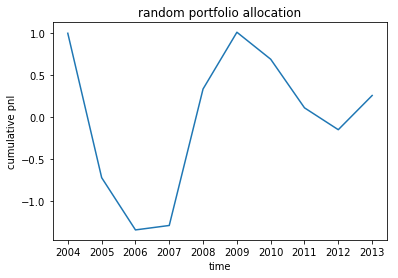

In [68]:
plot(dates, pnl_series_1)
pylab.xlabel('time')
pylab.ylabel('cumulative pnl')
pylab.title('random portfolio allocation')

In [69]:

pnl_series_1, ret_series_1 = test_long_short_1(df)
mean_ret = np.mean(ret_series_1)
std_ret = np.std(ret_series_1)
sharpe_ratio = mean_ret/std_ret
print 'sharpe ratio = ' + str(sharpe_ratio)


sharpe ratio = 0.107895275051


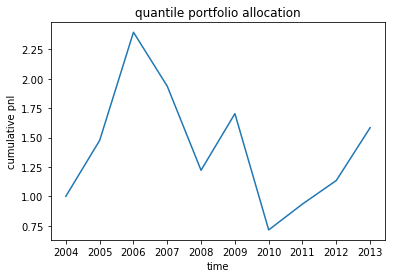

In [60]:
plot(dates, pnl_series_1)
pylab.xlabel('time')
pylab.ylabel('cumulative pnl')
pylab.title('quantile portfolio allocation')

### Long Short portfolio using alpha forcast approch

In [61]:
pnl_series_1, ret_series_1 = test_long_short_2(df)
mean_ret = np.mean(ret_series_1)
std_ret = np.std(ret_series_1)
sharpe_ratio = mean_ret/std_ret
print 'sharpe ratio = ' + str(sharpe_ratio)



sharpe ratio = 0.473247104823


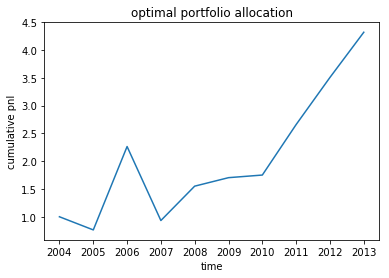

In [62]:
plot(dates,pnl_series_1)
pylab.xlabel('time')
pylab.ylabel('cumulative pnl')
pylab.title('optimal portfolio allocation')

In [ ]:
import random
random.seed(10)
random.sample(range(signals.shape[1]), 10)